In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from src import vrae, train, utils
import numpy as np

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Feature col

In [2]:
batch_size = 64
time_size = 256
over_len = 128

# Load Data

In [3]:
folder_path = "/works/Data/wellysis/mit-bih-long-term-ecg-database-1.0.0/"
data_col = utils.data_from_mit(folder_path)

In [4]:
print("Data Name List : {}".format(list(data_col.keys())))

Data Name List : ['14046', '14134', '14149', '14157', '14172', '14184', '15814']


In [5]:
data_sample = utils.make_dataformat_from_mit(data_col=data_col, name='14046', time_len=time_size, over_len=over_len)

print(data_sample.shape, data_sample.max(), data_sample.min())

(84599, 256, 1) 1.0 0.0


# Make train set to tensor & Load Model

# VRAE

In [6]:
train_set = utils.tensorset(arr = data_sample, shape=(-1, time_size, 1), batch_size=batch_size)

mod = vrae.VRAE(hidden_size=128, latent_length=30, output_depth=1, time_size=time_size, dropout=0.3, recurrent_dropout=0.3)

mod.build(input_shape=(batch_size,time_size,1))
mod.summary()

Before reshape : (84599, 256, 1)
After reshape : (84599, 256, 1) | data type : float32
Model: "vrae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Ecoding_RNN_Cell (SimpleRNNC multiple                  16640     
_________________________________________________________________
RNN_Wrapper (RNN)            multiple                  16640     
_________________________________________________________________
Encoding_MU_Dense (Dense)    multiple                  3870      
_________________________________________________________________
Encoding_STD_Dense (Dense)   multiple                  3870      
_________________________________________________________________
Decoding_first_state_Dense ( multiple                  3968      
_________________________________________________________________
Decoding_RNN_Cell (SimpleRNN multiple                  16640     
_________________________________________

In [7]:
# "/works/GitLab/jomjam/Python/AnomalyDetection/ECG/logs"
train_loss_results = train.train(model=mod, train_dataset=train_set, epochs=30, learning_rate=0.0001, summary_dir="/works/GitLab/jomjam/Python/AnomalyDetection/ECG/logs", add_name="_mit_2s_rnn_128enc_30z_128dec_kldScheduling")

EPOCH : 000 | ELBO : 277.731 | Reconstruct : 177.274 | KLD : 100.457 | MSE : 0.001227
EPOCH : 005 | ELBO : 361.220 | Reconstruct : 177.240 | KLD : 183.979 | MSE : 0.001163
EPOCH : 010 | ELBO : 343.407 | Reconstruct : 177.240 | KLD : 166.167 | MSE : 0.001163
EPOCH : 015 | ELBO : 311.750 | Reconstruct : 177.240 | KLD : 134.510 | MSE : 0.001163
EPOCH : 020 | ELBO : 177.245 | Reconstruct : 177.241 | KLD : 0.005 | MSE : 0.001164
EPOCH : 025 | ELBO : 177.243 | Reconstruct : 177.240 | KLD : 0.003 | MSE : 0.001163


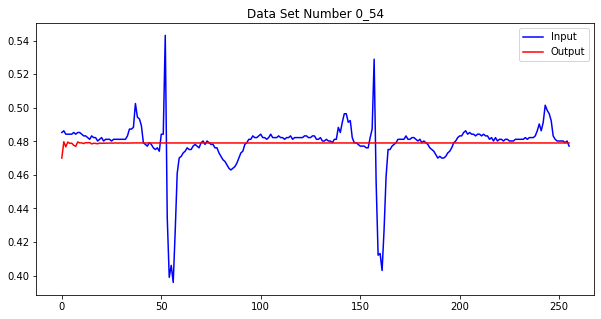

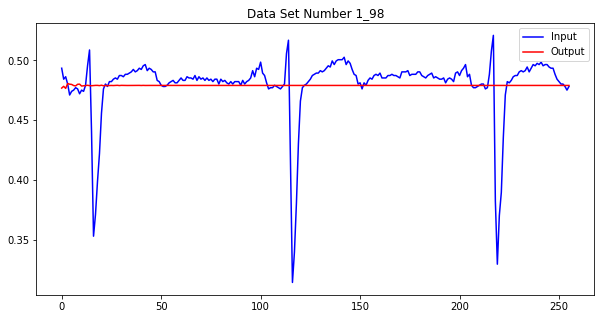

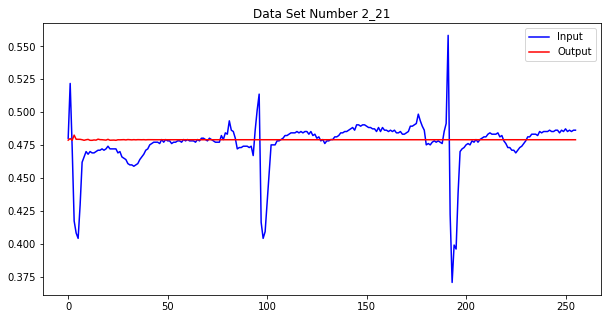

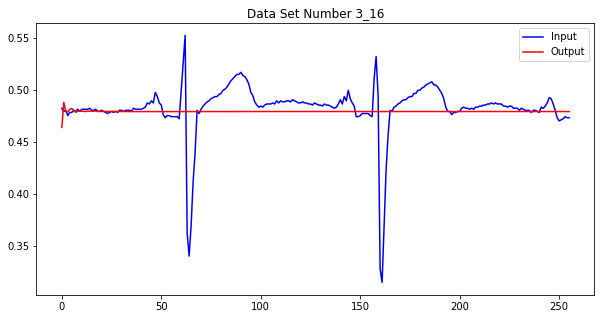

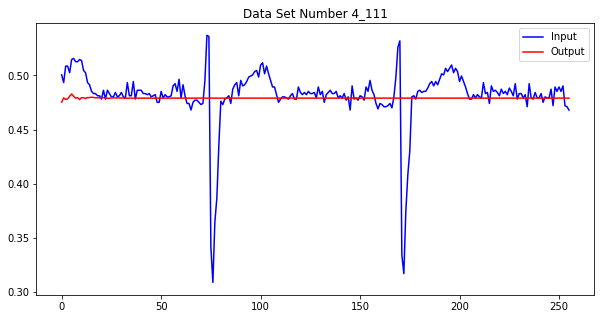

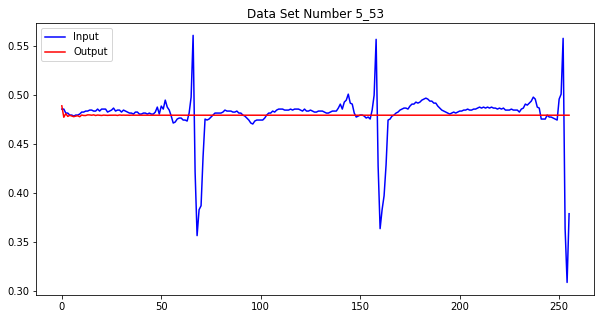

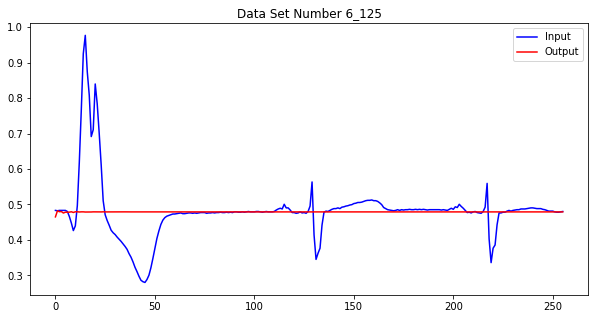

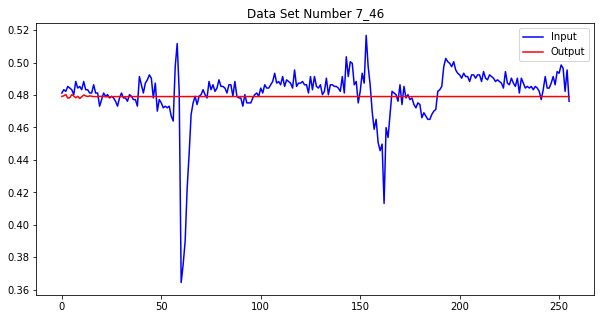

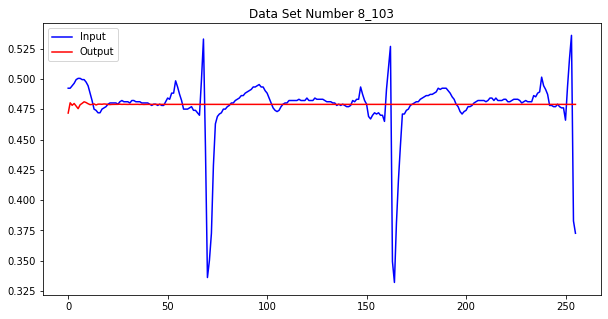

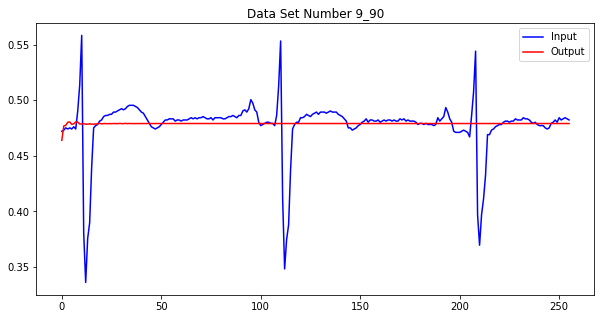

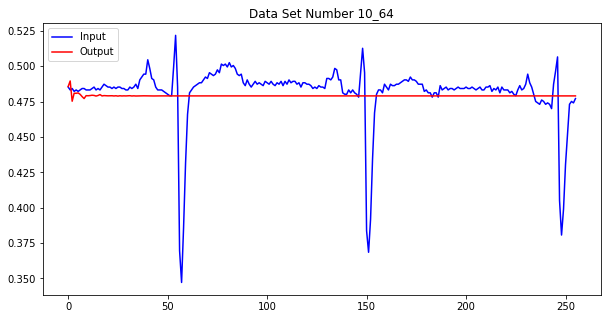

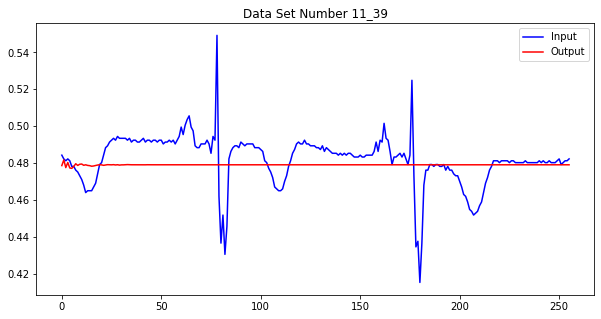

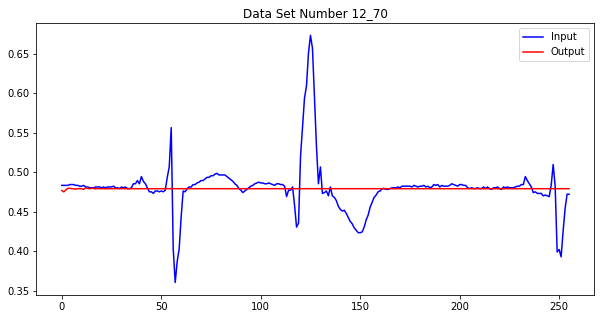

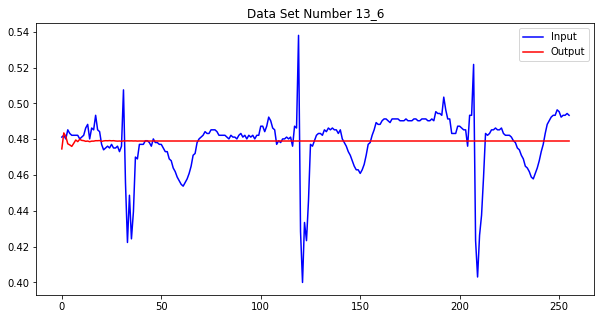

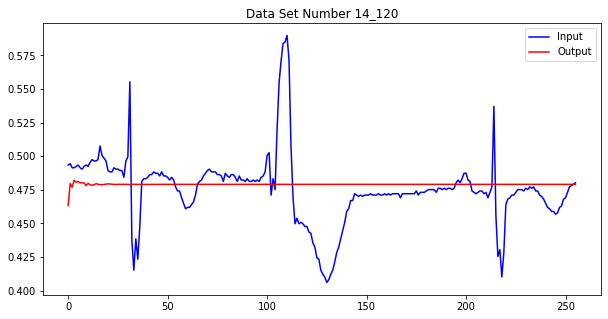

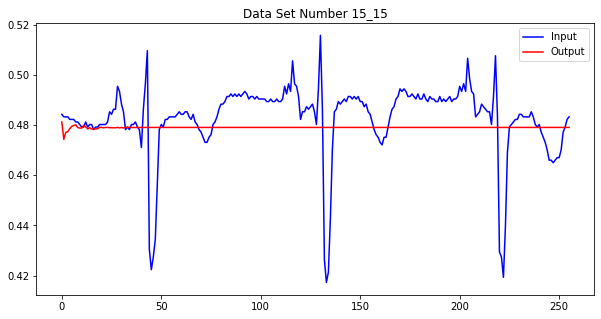

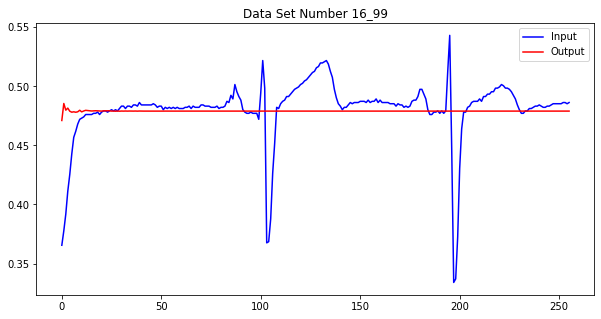

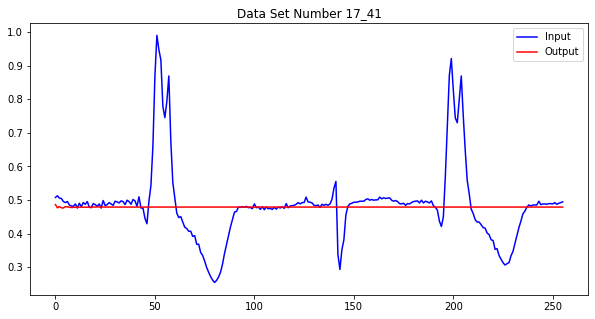

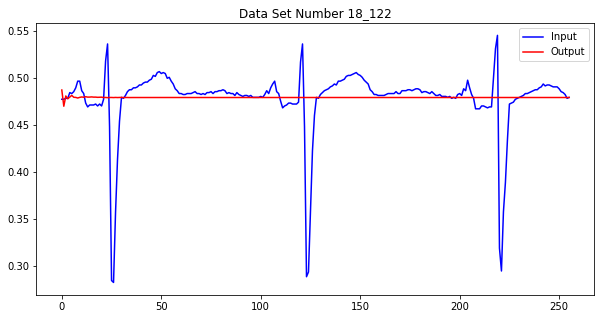

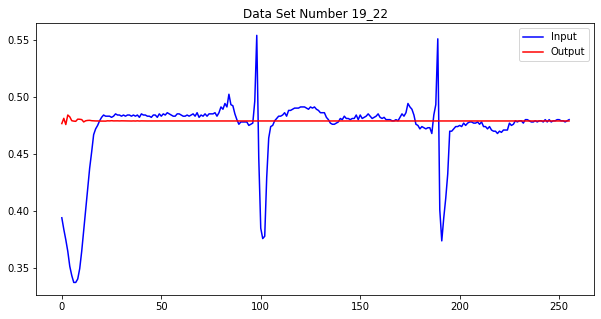

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

show_num = 20
show_idx = 0

for x in train_set:
    output, _, _ = mod(x)
    x_arr = x.numpy().reshape(batch_size, time_size)
    y_arr = output.numpy().reshape(batch_size, time_size)
    random_idx = np.random.permutation(x_arr.shape[0])[0]
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.plot(np.arange(time_size), x_arr[random_idx], label="Input", color="b")
    ax.plot(np.arange(time_size), y_arr[random_idx], label="Output", color="r")
    ax.legend()
    ax.set_title("Data Set Number {}_{}".format(show_idx, random_idx))
    plt.show()
    
    show_idx += 1
    
    if show_idx == show_num:
        break

# Simple AE

In [6]:
from src import ae

train_set = utils.tensorset(arr = data_sample, shape=(-1, time_size, 1), batch_size=batch_size)

simple_ae = ae.AE(hidden_size=128, latent_length=30, output_depth=1, time_size=time_size, dropout=0.3, recurrent_dropout=0.3)

simple_ae.build(input_shape=(batch_size,time_size,1))
simple_ae.summary()

Before reshape : (84599, 256, 1)
After reshape : (84599, 256, 1) | data type : float32
Model: "ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Ecoding_RNN_Cell (SimpleRNNC multiple                  16640     
_________________________________________________________________
RNN_Wrapper (RNN)            multiple                  16640     
_________________________________________________________________
Encoding_OutPut_Dense (Dense multiple                  3870      
_________________________________________________________________
Decoding_first_state_Dense ( multiple                  3968      
_________________________________________________________________
Decoding_RNN_Cell (SimpleRNN multiple                  16640     
_________________________________________________________________
Decoding_Output (Dense)      multiple                  129       
Total params: 41,247
Trainable params: 41,2

In [8]:
train_loss_results = ae.train(model=simple_ae, train_dataset=train_set, epochs=30, learning_rate=0.0001,\
                                 summary_dir="/works/GitLab/jomjam/Python/AnomalyDetection/ECG/logs",\
                                 add_name="_mit_2s_simpleAE_128enc_30z_128dec_loglikelihood")

EPOCH : 000 | Reconstruct : 177.257 | MSE : 0.001195
EPOCH : 005 | Reconstruct : 177.240 | MSE : 0.001162
EPOCH : 010 | Reconstruct : 177.226 | MSE : 0.001136
EPOCH : 015 | Reconstruct : 177.222 | MSE : 0.001127
EPOCH : 020 | Reconstruct : 177.226 | MSE : 0.001135
EPOCH : 025 | Reconstruct : 177.224 | MSE : 0.001131


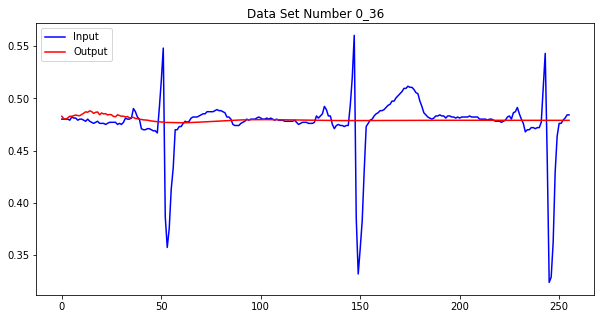

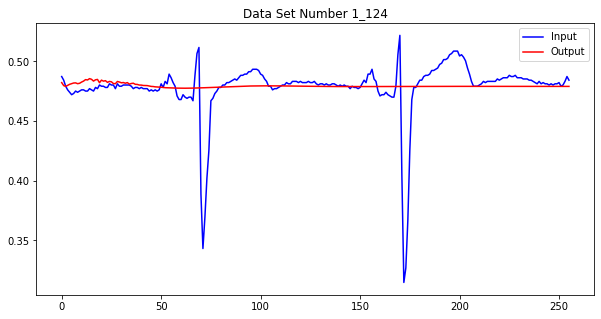

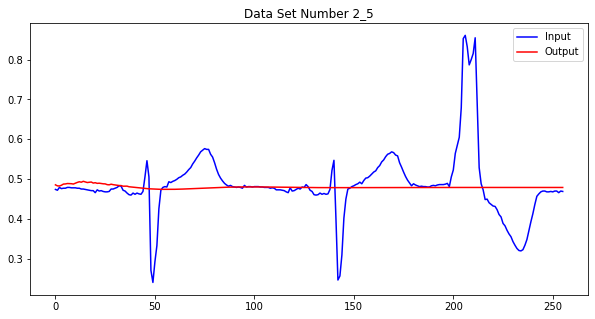

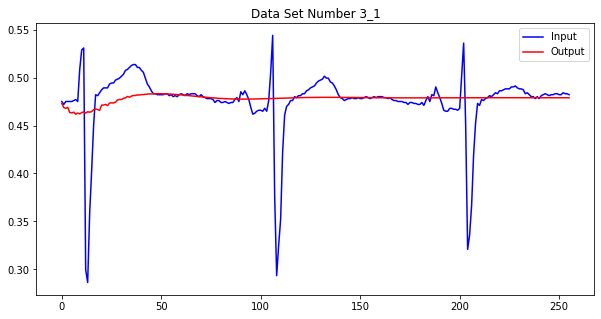

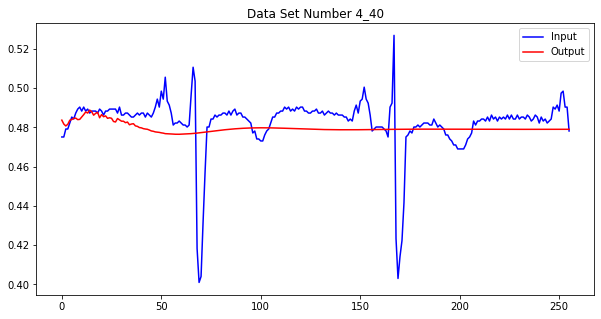

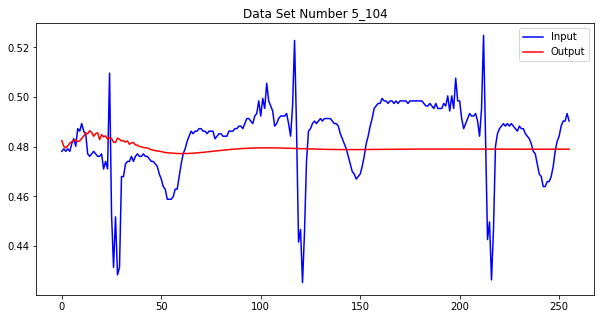

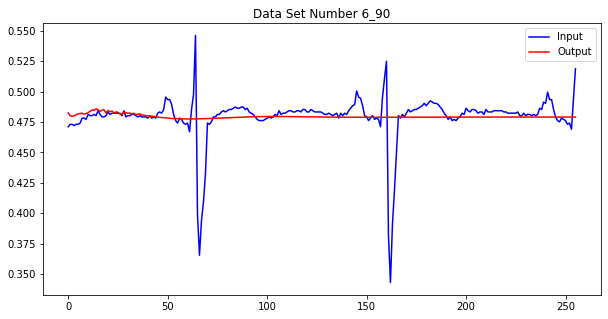

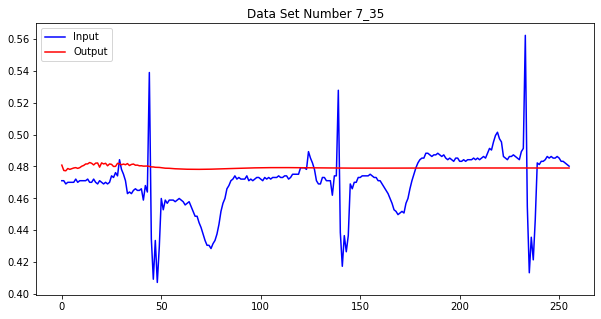

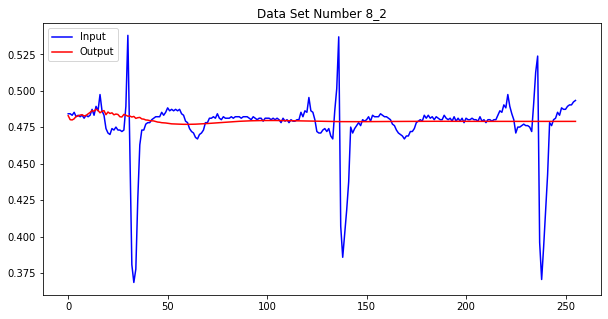

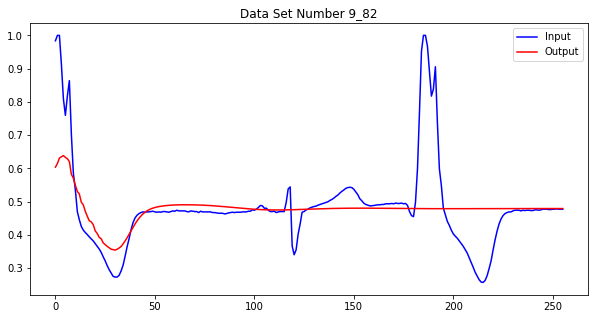

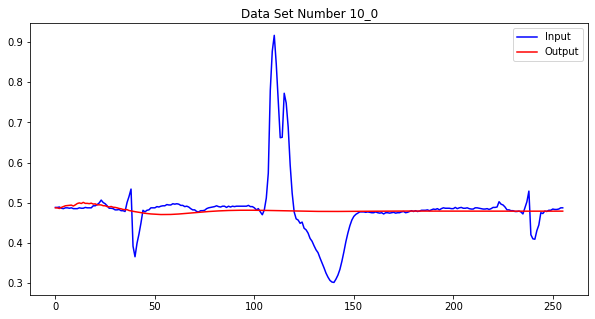

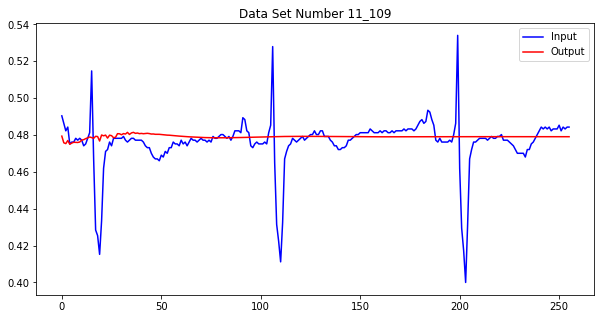

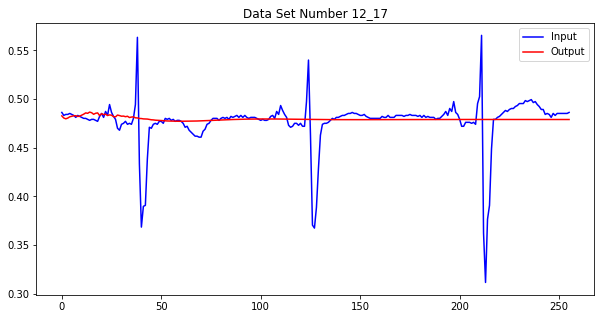

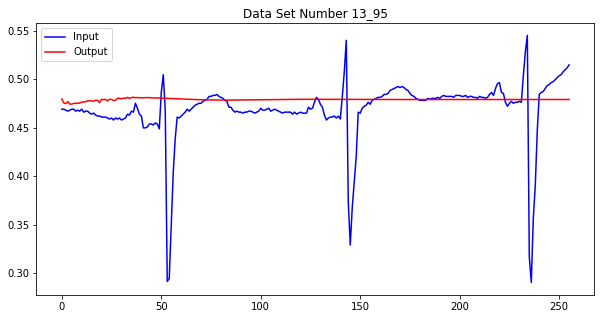

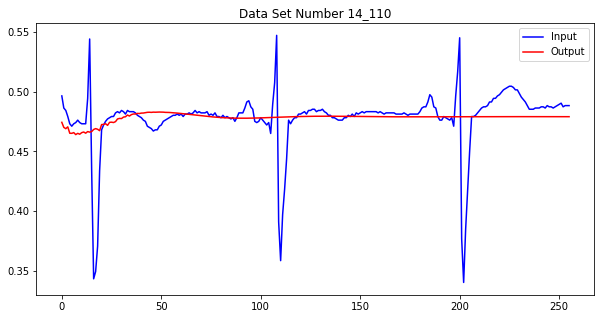

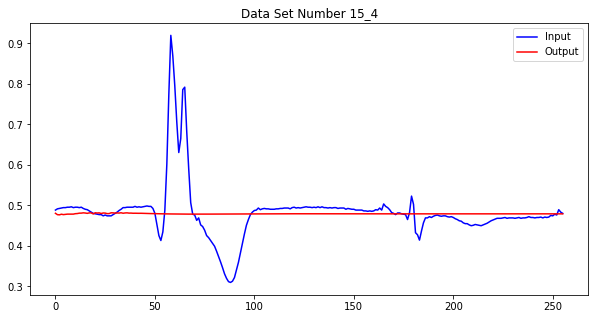

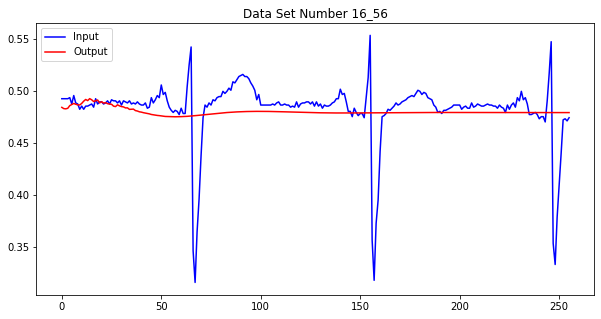

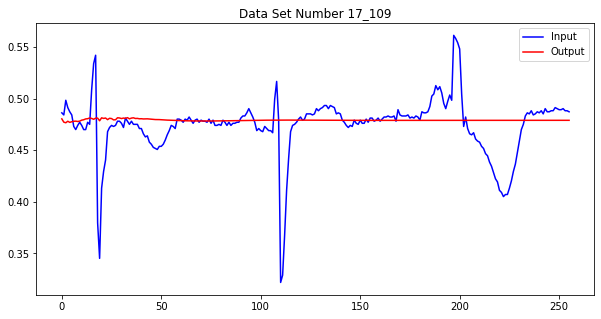

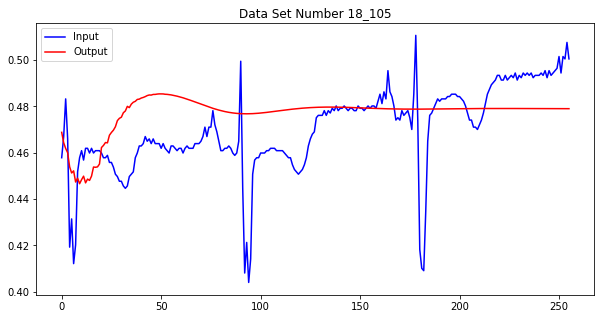

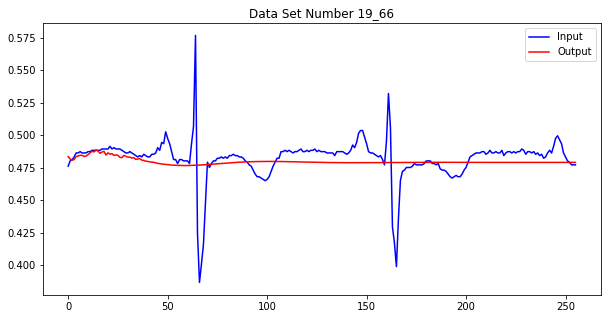

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

show_num = 20
show_idx = 0

for x in train_set:
    output = simple_ae(x)
    x_arr = x.numpy().reshape(batch_size, time_size)
    y_arr = output.numpy().reshape(batch_size, time_size)
    random_idx = np.random.permutation(x_arr.shape[0])[0]
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.plot(np.arange(time_size), x_arr[random_idx], label="Input", color="b")
    ax.plot(np.arange(time_size), y_arr[random_idx], label="Output", color="r")
    ax.legend()
    ax.set_title("Data Set Number {}_{}".format(show_idx, random_idx))
    plt.show()
    
    show_idx += 1
    
    if show_idx == show_num:
        break

# Simple AE + mse loss

In [13]:
from src import ae

train_set = utils.tensorset(arr = data_sample, shape=(-1, time_size, 1), batch_size=batch_size)

simple_ae = ae.AE(hidden_size=128, latent_length=30, output_depth=1, time_size=time_size, dropout=0.3, recurrent_dropout=0.3)

simple_ae.build(input_shape=(batch_size,time_size,1))
simple_ae.summary()

Before reshape : (84599, 256, 1)
After reshape : (84599, 256, 1) | data type : float32
Model: "ae_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Ecoding_RNN_Cell (SimpleRNNC multiple                  16640     
_________________________________________________________________
RNN_Wrapper (RNN)            multiple                  16640     
_________________________________________________________________
Encoding_OutPut_Dense (Dense multiple                  3870      
_________________________________________________________________
Decoding_first_state_Dense ( multiple                  3968      
_________________________________________________________________
Decoding_RNN_Cell (SimpleRNN multiple                  16640     
_________________________________________________________________
Decoding_Output (Dense)      multiple                  129       
Total params: 41,247
Trainable params: 41

In [14]:
train_loss_results = ae.train(model=simple_ae, train_dataset=train_set, epochs=100, learning_rate=0.0001,\
                                 summary_dir="/works/GitLab/jomjam/Python/AnomalyDetection/ECG/logs",\
                                 add_name="_mit_2s_simpleAE_128enc_30z_128dec_mse")

EPOCH : 000 | Reconstruct : 177.247 | MSE : 0.001176
EPOCH : 005 | Reconstruct : 177.175 | MSE : 0.001036
EPOCH : 010 | Reconstruct : 177.140 | MSE : 0.000968
EPOCH : 015 | Reconstruct : 177.080 | MSE : 0.000854
EPOCH : 020 | Reconstruct : 177.082 | MSE : 0.000859
EPOCH : 025 | Reconstruct : 177.006 | MSE : 0.000715
EPOCH : 030 | Reconstruct : 176.937 | MSE : 0.000585
EPOCH : 035 | Reconstruct : 176.918 | MSE : 0.000550
EPOCH : 040 | Reconstruct : 177.194 | MSE : 0.001072
EPOCH : 045 | Reconstruct : 177.063 | MSE : 0.000822
EPOCH : 050 | Reconstruct : 176.902 | MSE : 0.000520
EPOCH : 055 | Reconstruct : 176.874 | MSE : 0.000467
EPOCH : 060 | Reconstruct : 176.843 | MSE : 0.000410
EPOCH : 065 | Reconstruct : 176.843 | MSE : 0.000409
EPOCH : 070 | Reconstruct : 176.824 | MSE : 0.000375
EPOCH : 075 | Reconstruct : 176.816 | MSE : 0.000360
EPOCH : 080 | Reconstruct : 176.819 | MSE : 0.000365
EPOCH : 085 | Reconstruct : 176.812 | MSE : 0.000351
EPOCH : 090 | Reconstruct : 176.805 | MSE : 0.

### 위 형식으로 30 Epochs 까지

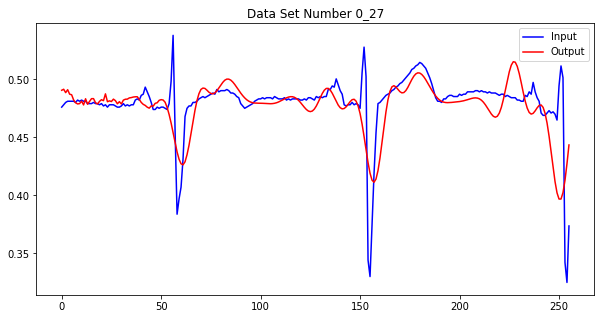

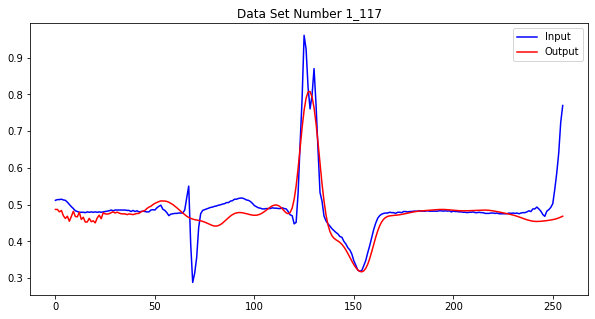

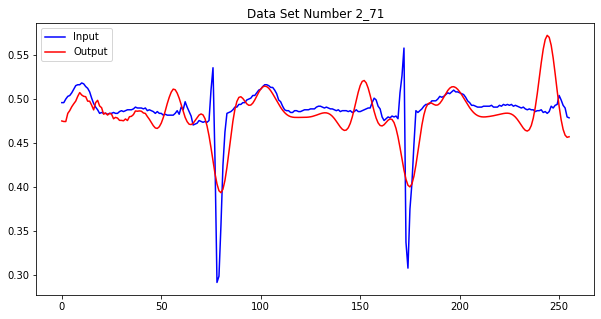

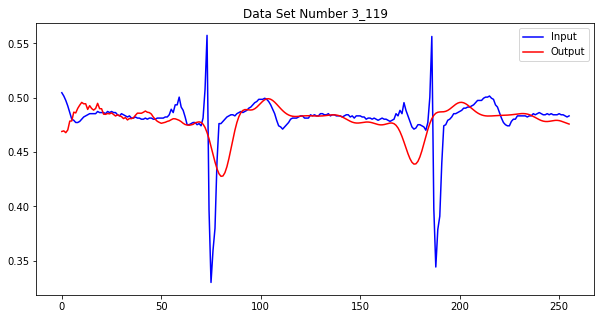

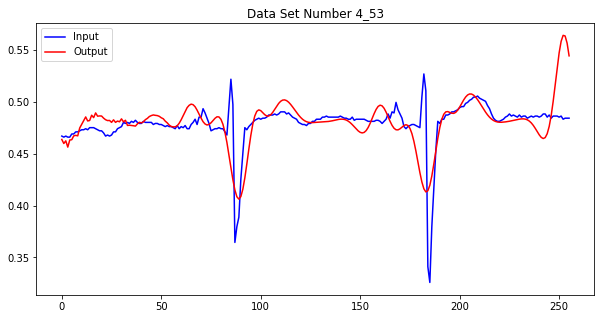

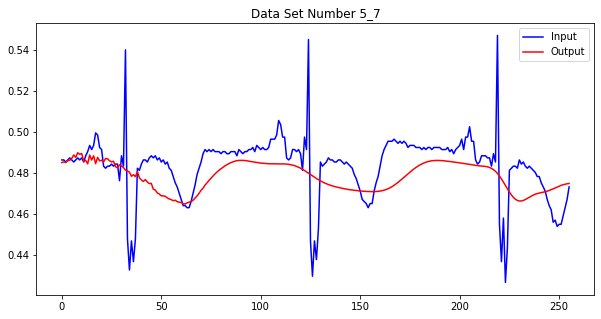

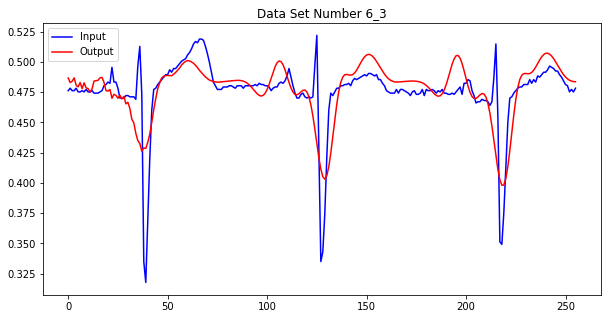

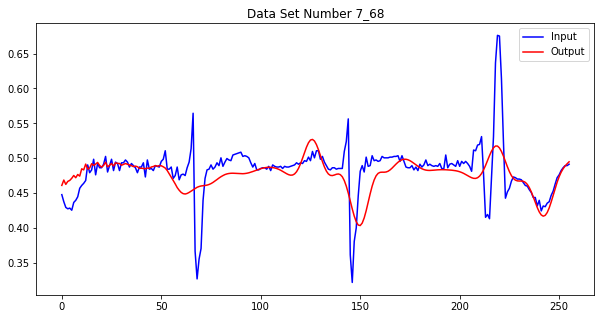

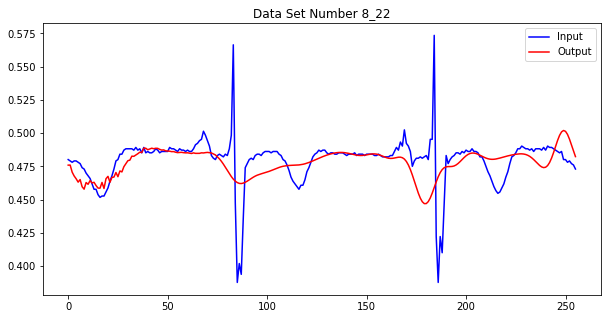

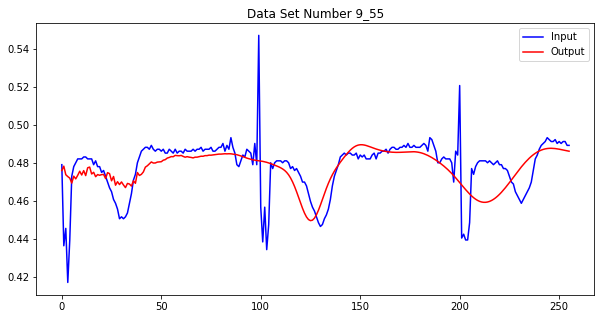

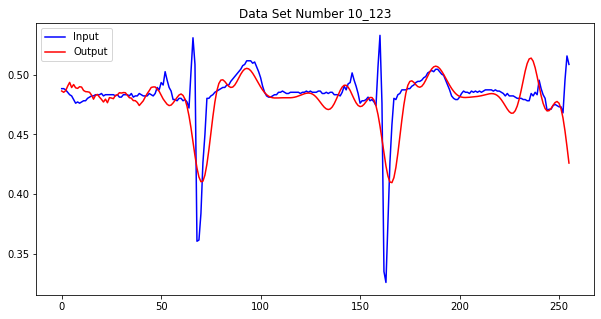

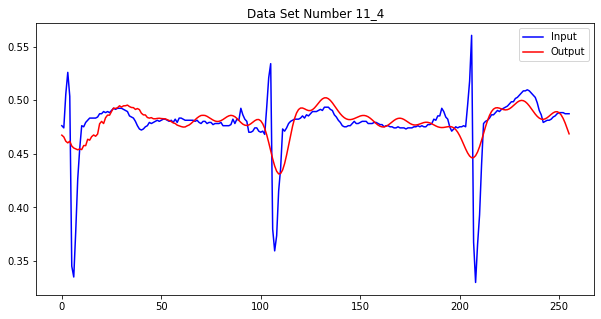

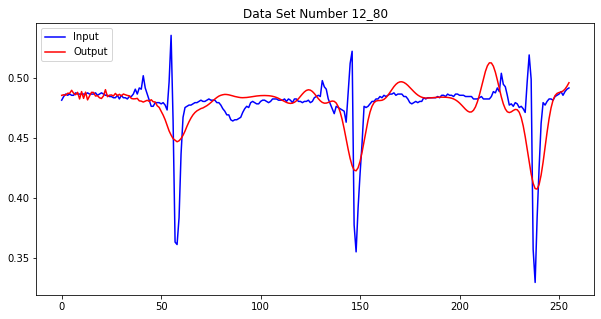

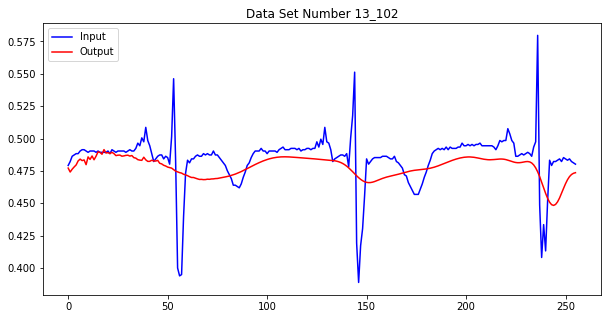

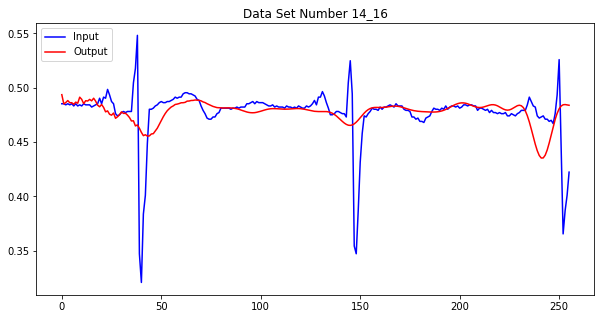

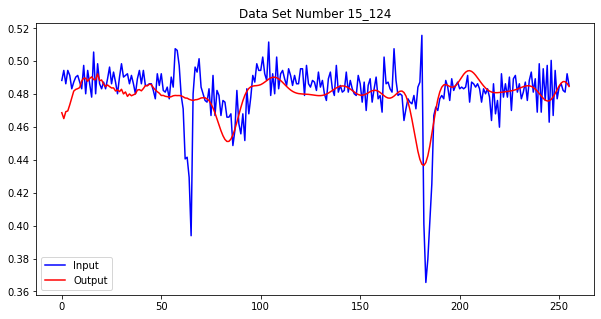

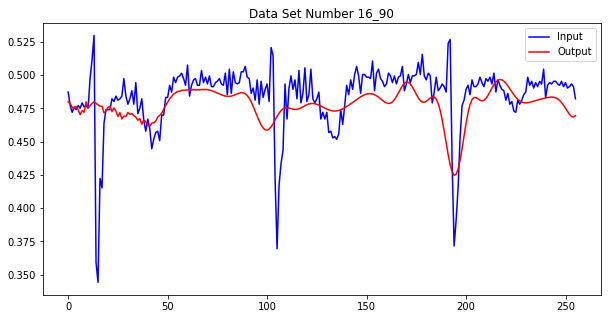

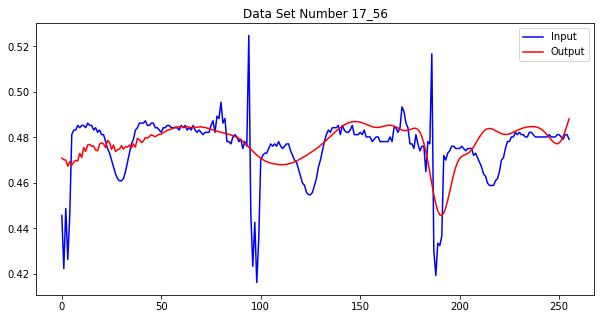

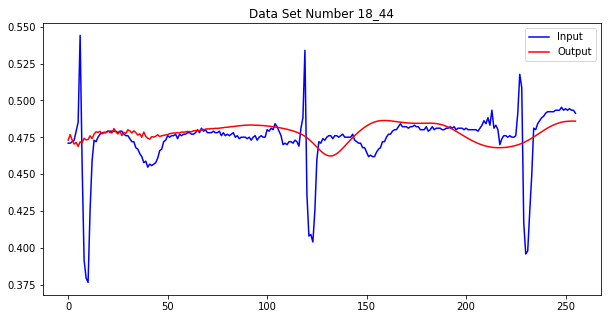

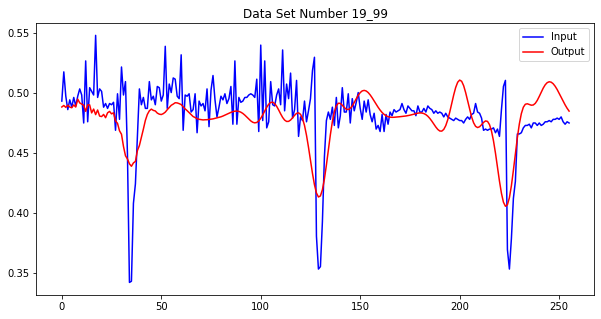

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

show_num = 20
show_idx = 0

for x in train_set:
    output = simple_ae(x)
    x_arr = x.numpy().reshape(batch_size, time_size)
    y_arr = output.numpy().reshape(batch_size, time_size)
    random_idx = np.random.permutation(x_arr.shape[0])[0]
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.plot(np.arange(time_size), x_arr[random_idx], label="Input", color="b")
    ax.plot(np.arange(time_size), y_arr[random_idx], label="Output", color="r")
    ax.legend()
    ax.set_title("Data Set Number {}_{}".format(show_idx, random_idx))
    plt.show()
    
    show_idx += 1
    
    if show_idx == show_num:
        break

### 100 Epoch 까지

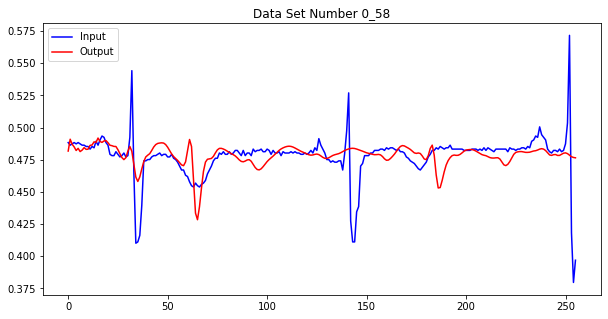

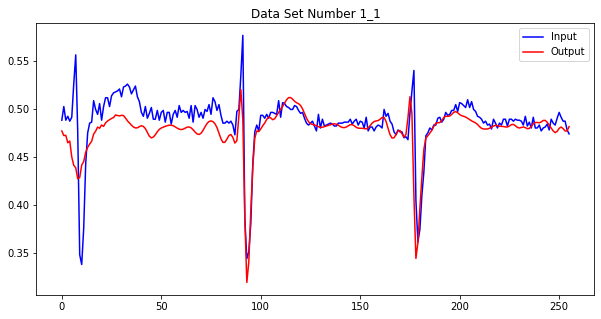

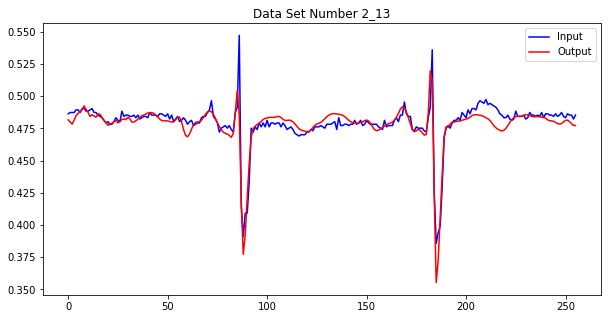

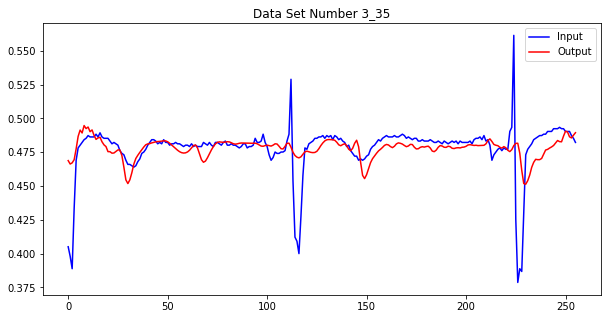

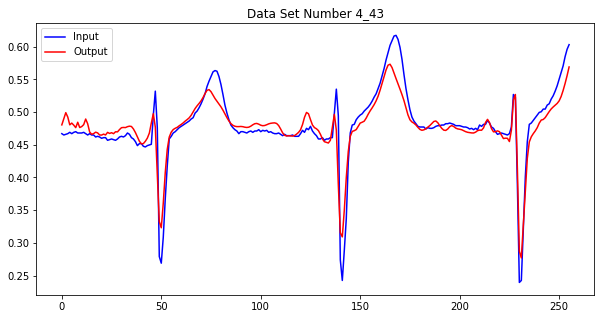

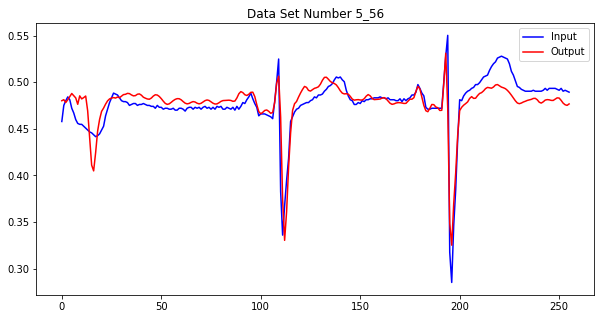

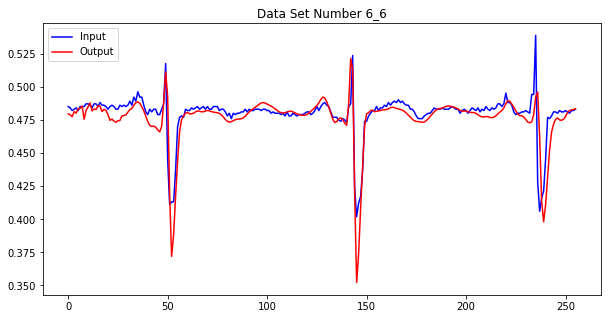

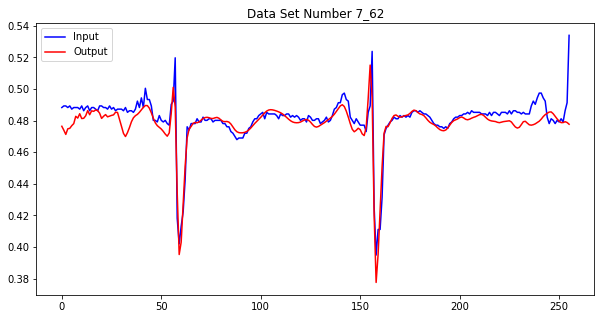

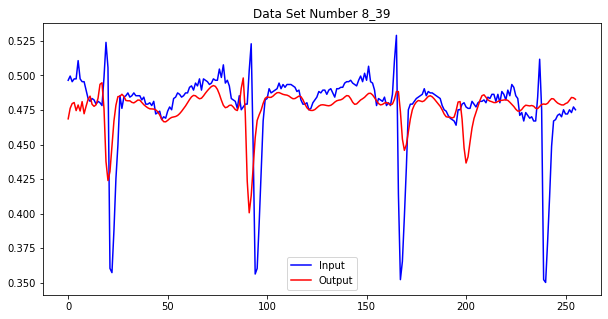

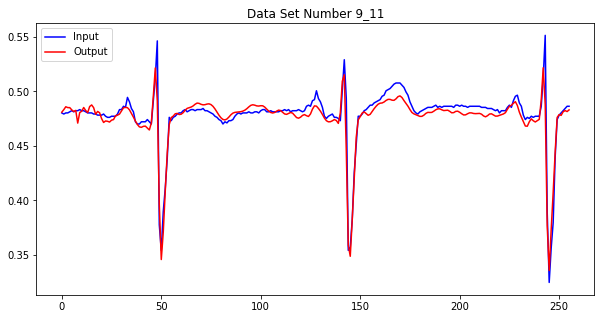

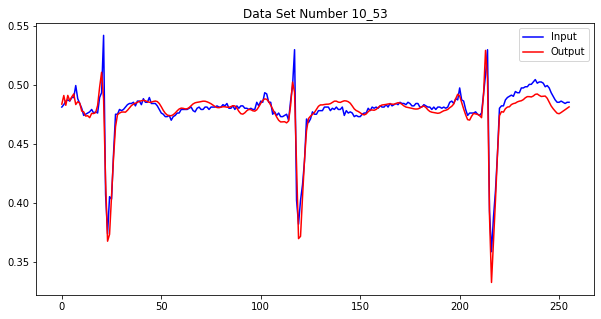

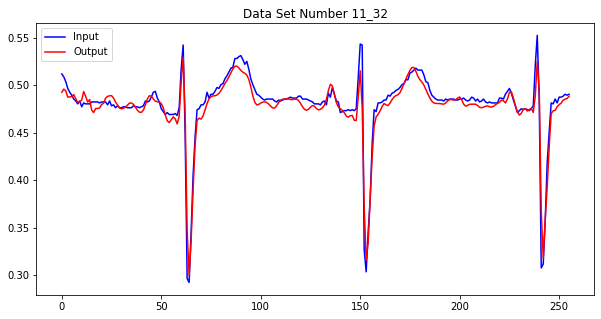

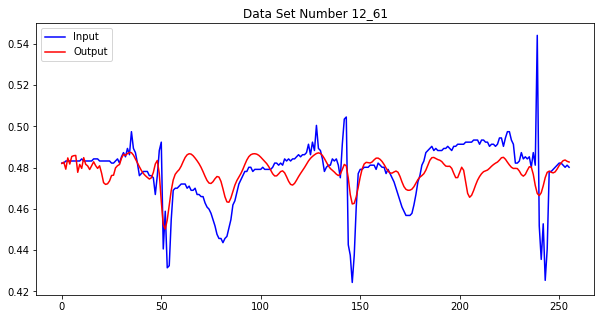

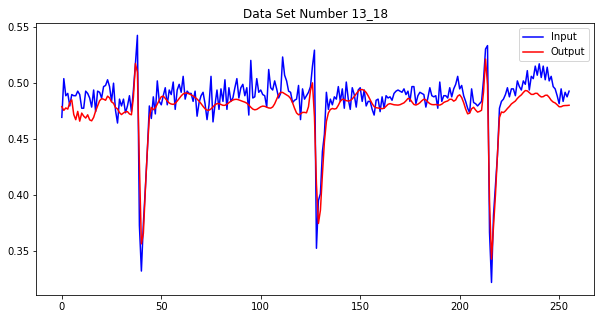

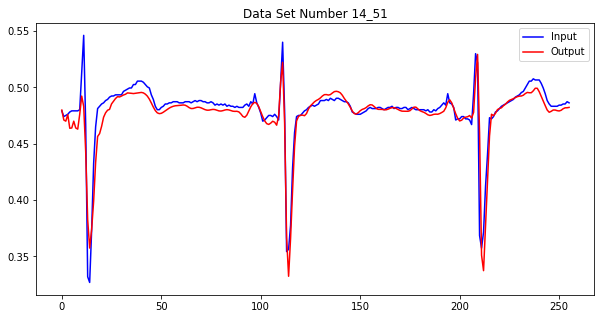

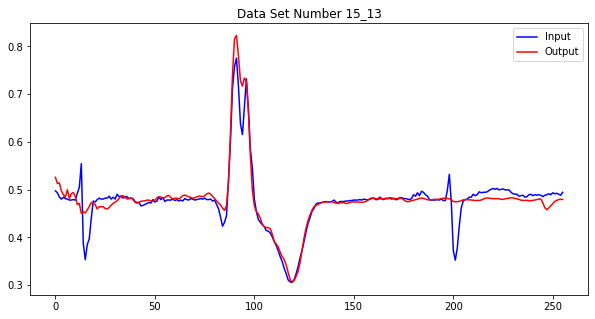

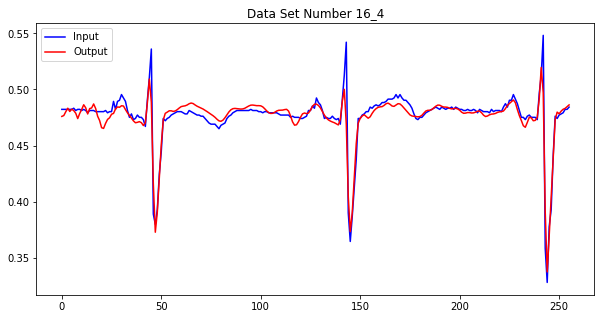

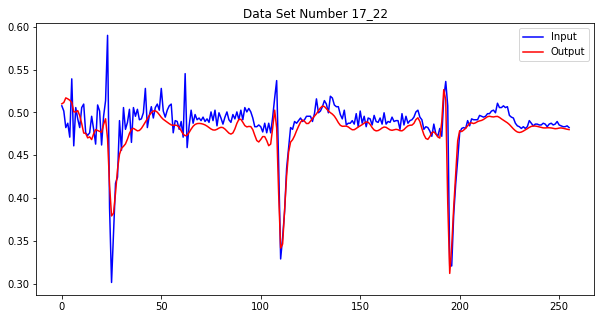

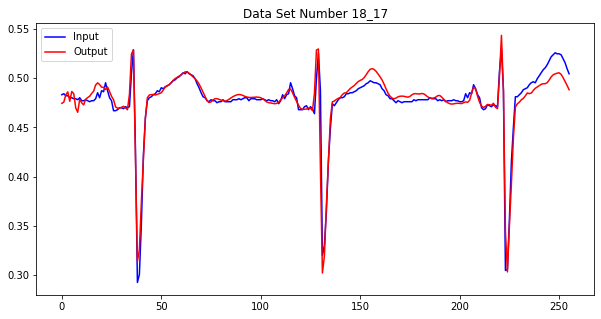

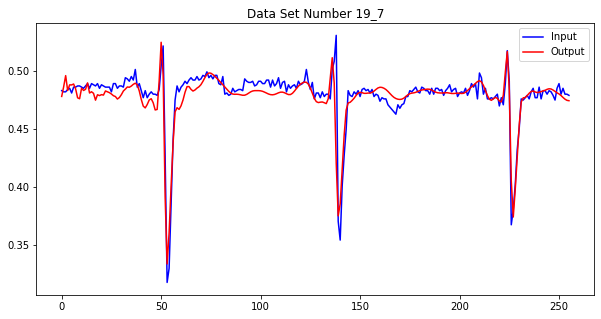

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

show_num = 20
show_idx = 0

for x in train_set:
    output = simple_ae(x)
    x_arr = x.numpy().reshape(batch_size, time_size)
    y_arr = output.numpy().reshape(batch_size, time_size)
    random_idx = np.random.permutation(x_arr.shape[0])[0]
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.plot(np.arange(time_size), x_arr[random_idx], label="Input", color="b")
    ax.plot(np.arange(time_size), y_arr[random_idx], label="Output", color="r")
    ax.legend()
    ax.set_title("Data Set Number {}_{}".format(show_idx, random_idx))
    plt.show()
    
    show_idx += 1
    
    if show_idx == show_num:
        break

# VRAE 출력을 Normal Distribution에 적용

In [6]:
from src import vrae_normal

In [7]:
train_set = utils.tensorset(arr = data_sample, shape=(-1, time_size, 1), batch_size=batch_size)

mod = vrae_normal.VRAE(hidden_size=128, latent_length=30, output_depth=1, time_size=time_size, dropout=0.3, recurrent_dropout=0.3)

mod.build(input_shape=(batch_size,time_size,1))
mod.summary()

Before reshape : (84599, 256, 1)
After reshape : (84599, 256, 1) | data type : float32
Model: "vrae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Ecoding_RNN_Cell (SimpleRNNC multiple                  16640     
_________________________________________________________________
RNN_Wrapper (RNN)            multiple                  16640     
_________________________________________________________________
Encoding_MU_Dense (Dense)    multiple                  3870      
_________________________________________________________________
Encoding_STD_Dense (Dense)   multiple                  3870      
_________________________________________________________________
Decoding_first_state_Dense ( multiple                  3968      
_________________________________________________________________
Decoding_RNN_Cell (SimpleRNN multiple                  16640     
_________________________________________

In [8]:
# "/works/GitLab/jomjam/Python/AnomalyDetection/ECG/logs"
train_loss_results = vrae_normal.train(model=mod, train_dataset=train_set, epochs=100, learning_rate=0.0001,\
                                       summary_dir= "/works/GitLab/jomjam/Python/AnomalyDetection/ECG/logs",\
                                       add_name="_mit_2s_VRAE_128enc_30z_128dec_mseLikelihood_kldScheduling",\
                                       cp_dir="/works/GitLab/jomjam/Python/AnomalyDetection/ECG/save")

EPOCH : 000 | ELBO : 75.723 | Reconstruct : 0.700 | KLD : 75.022 | MSE : 0.005473
EPOCH : 005 | ELBO : 180.677 | Reconstruct : 0.150 | KLD : 180.528 | MSE : 0.001168
EPOCH : 010 | ELBO : 235.562 | Reconstruct : 0.149 | KLD : 235.413 | MSE : 0.001166
EPOCH : 015 | ELBO : 281.164 | Reconstruct : 0.149 | KLD : 281.015 | MSE : 0.001165
EPOCH : 020 | ELBO : 305.140 | Reconstruct : 0.149 | KLD : 304.991 | MSE : 0.001165
EPOCH : 025 | ELBO : 322.189 | Reconstruct : 0.149 | KLD : 322.040 | MSE : 0.001165
EPOCH : 030 | ELBO : 335.008 | Reconstruct : 0.149 | KLD : 334.859 | MSE : 0.001164
EPOCH : 035 | ELBO : 349.640 | Reconstruct : 0.149 | KLD : 349.491 | MSE : 0.001164
EPOCH : 040 | ELBO : 363.598 | Reconstruct : 0.149 | KLD : 363.449 | MSE : 0.001164
EPOCH : 045 | ELBO : 378.880 | Reconstruct : 0.149 | KLD : 378.731 | MSE : 0.001164
EPOCH : 050 | ELBO : 398.325 | Reconstruct : 0.149 | KLD : 398.176 | MSE : 0.001164
EPOCH : 055 | ELBO : 0.168 | Reconstruct : 0.153 | KLD : 0.014 | MSE : 0.00119

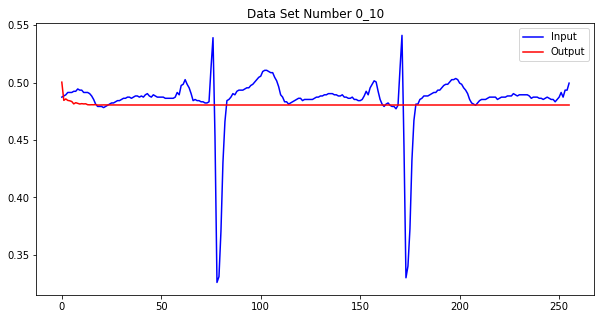

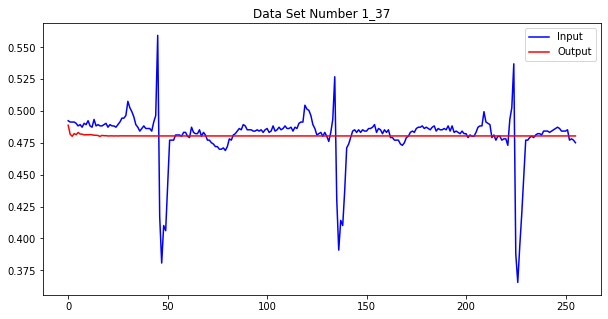

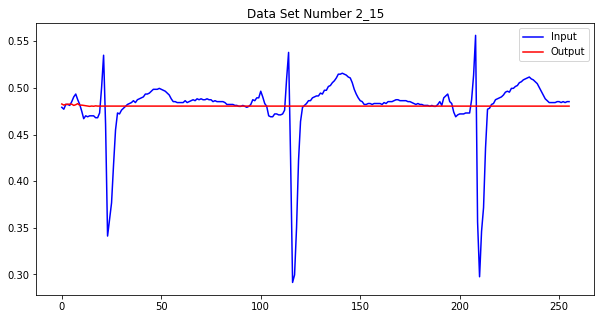

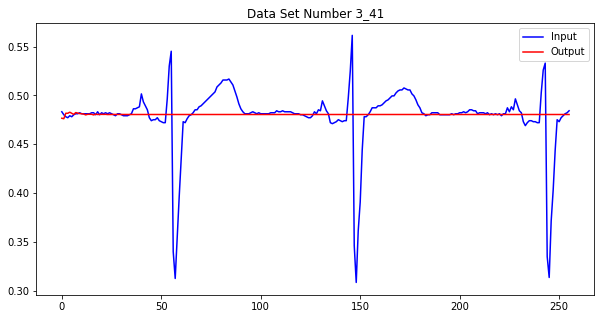

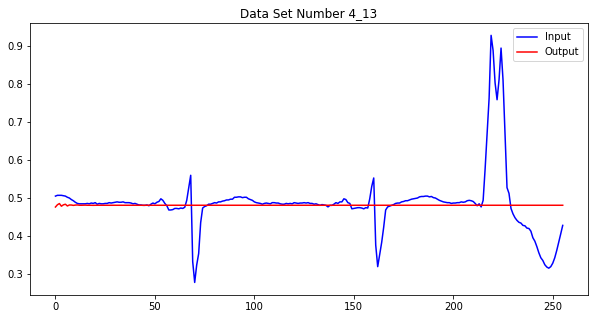

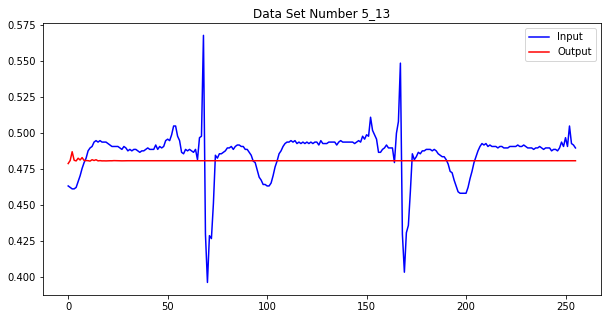

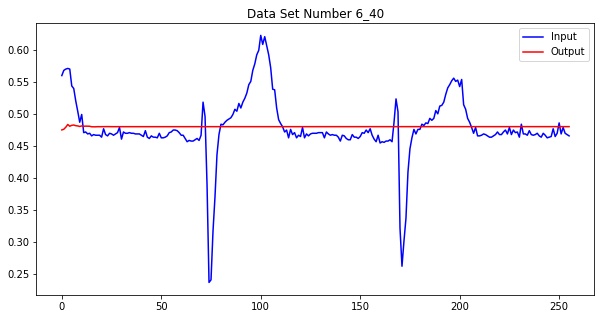

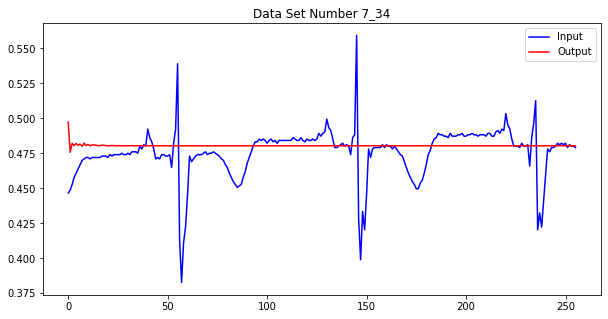

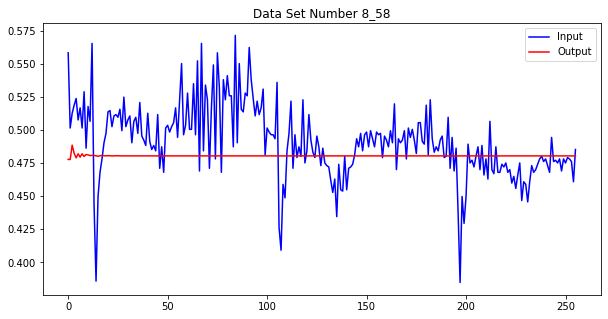

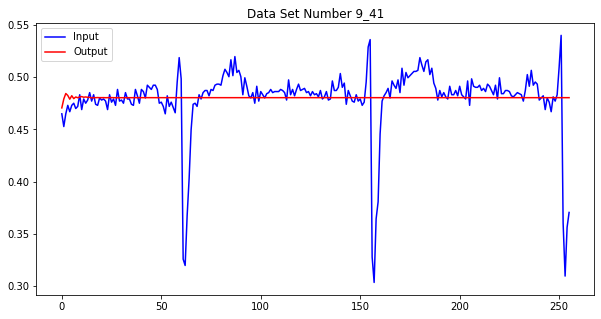

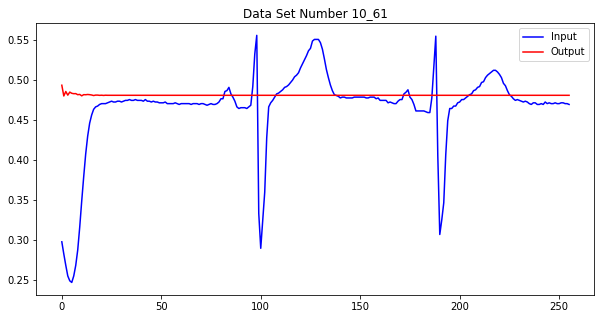

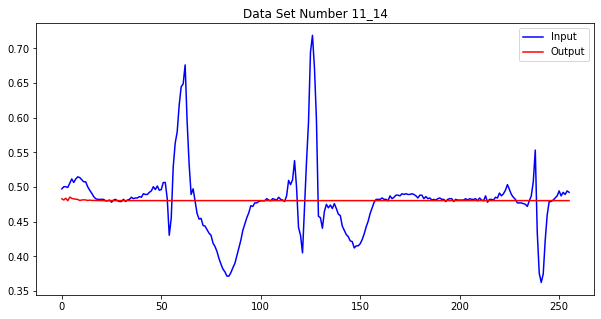

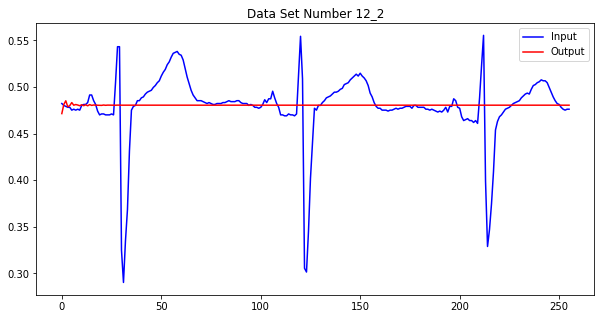

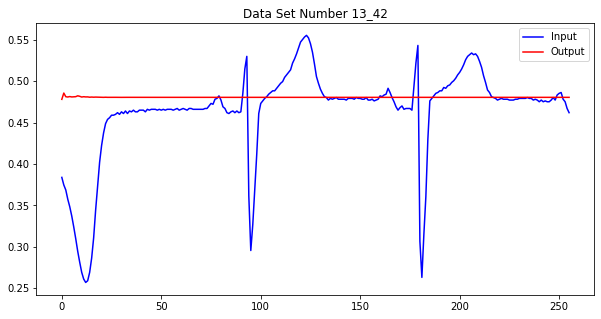

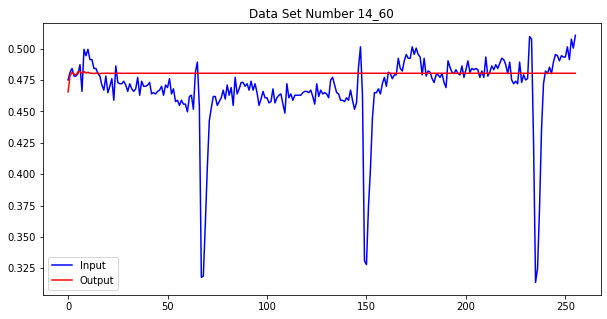

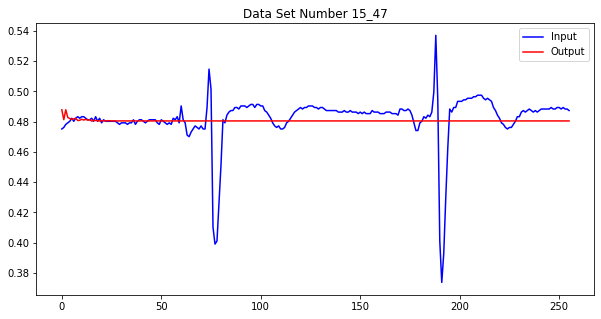

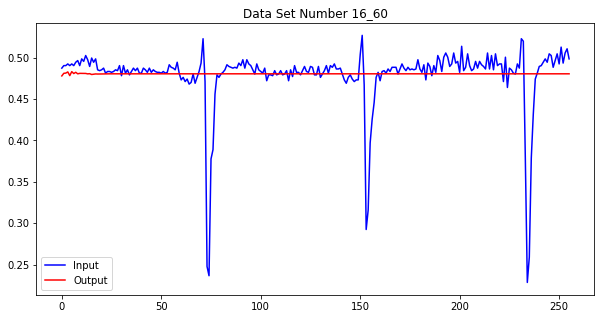

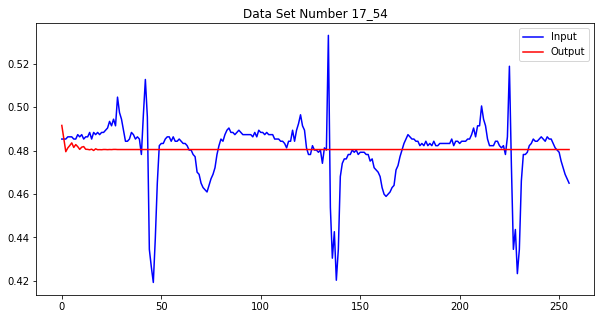

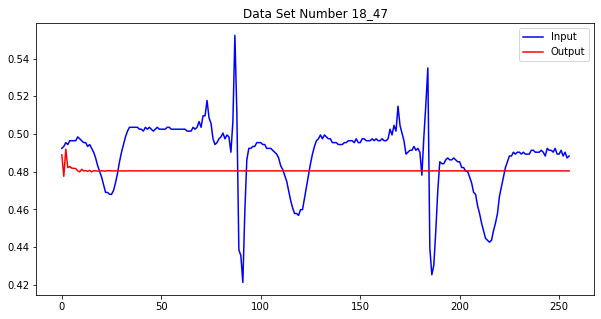

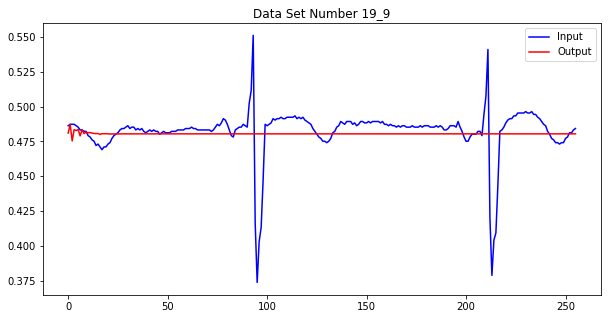

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

show_num = 20
show_idx = 0

for x in train_set:
    output, _, _ = mod(x)
    x_arr = x.numpy().reshape(batch_size, time_size)
    y_arr = output.numpy().reshape(batch_size, time_size)
    random_idx = np.random.permutation(x_arr.shape[0])[0]
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.plot(np.arange(time_size), x_arr[random_idx], label="Input", color="b")
    ax.plot(np.arange(time_size), y_arr[random_idx], label="Output", color="r")
    ax.legend()
    ax.set_title("Data Set Number {}_{}".format(show_idx, random_idx))
    plt.show()
    
    show_idx += 1
    
    if show_idx == show_num:
        break